# **Spotify Network Analysis Project**

### Gal Gritzerstein - 316064773
### Daniel Mandelbaum - 316014570

In [2]:
from __future__ import print_function    # (at top of module)
from spotipy.oauth2 import SpotifyClientCredentials
import json
import spotipy
import time
import sys 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode,plot,iplot
from collections import OrderedDict
from math import log
import calmap
import spotipy as sp
import spotipy.util as util
import json
from pprint import pprint
import seaborn as sns
from scipy import stats
import numpy as np
import networkx as nx
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
from tqdm import tqdm
import requests
import os
import requests

To start our dataset we asked Yoni the request from Spotify all the data they've collected a him. This data includes his streaming history, he's saved songs in his library, his playlist and more. We are going to focus on his streaming history.

# Get soptify API access

## You will not be able to run the API calls to spotify because it uses our credentials and takes a lot of time

In [67]:
username = 'XXXXXXXXXXXXXXXX' 
client_id ='XXXXXXXXXXXXXXXX' 
client_secret = 'XXXXXXXXXXXXXXXX'
redirect_uri = 'http://localhost:7777/callback'
scope = 'user-read-recently-played'

token = util.prompt_for_user_token(username=username, 
scope=scope, 
client_id=client_id,   
client_secret=client_secret,     
redirect_uri=redirect_uri)

In [68]:
# generate access token
CLIENT_ID = 'XXXXXXXXXXXXXXXX'
CLIENT_SECRET = 'XXXXXXXXXXXXXXXX' 
# authentication URL
AUTH_URL = 'https://accounts.spotify.com/api/token'
scope = "user-library-read"
# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}
BASE_URL = 'https://api.spotify.com/v1/'
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(CLIENT_ID, CLIENT_SECRET, redirect_uri='http://localhost/', scope=scope))

# Creating the dataset

In [6]:
# read your StreamingHistory files into pandas dataframes
df_stream0 = pd.read_json('StreamingHistory0.json')
df_stream1 = pd.read_json('streamingHistory1.json')

# merge dataframes
data = pd.concat([df_stream0, df_stream1])

In [8]:
# Convert from JSON to a data frame

spotify_data = pd.DataFrame()

def extract_json_value(column_name):
    
    return [i[column_name] for i in data]

spotify_data['artist_name'] = data['artistName']
spotify_data['end_time'] = data['endTime']
spotify_data['ms_played'] = data['msPlayed']
spotify_data['track_name'] = data['trackName']

spotify_data.head()

,artist_name,end_time,ms_played,track_name
0,Chill Children,2020-12-07 08:50,32252,Pounds
1,Kid Cudi,2020-12-13 12:27,242266,"Solo Dolo, Pt. III"
2,Kid Cudi,2020-12-13 12:31,193293,Tequila Shots
3,Kid Cudi,2020-12-13 12:37,199786,Another Day
4,Kid Cudi,2020-12-13 12:38,15829,Another Day


## Obtain the track_IDs by using the API to search the name of our track

#### this code took a long time to run, it contain many API calls, we ran it once and saved the results to a CSV file (yoni_data_for_eda.csv)

In [ ]:
# write the function to get track_id
def get_id(track_name: str,artist:str, token: str) -> str:
    headers = {
    'Accept': 'application/json',
    'Content-Type': 'application/json',
    'Authorization': f'Bearer ' + token,
    }
    track_artist = track_name+ " " + artist
    params = [
    ('q',track_artist ),#q is the search query parameter
    ('type', 'track'),
    ]
    try:
        response = requests.get('https://api.spotify.com/v1/search', 
                    headers = headers, params = params, timeout = 10)
        json = response.json()
        first_result = json['tracks']['items'][0]
        track_id = first_result['id']
        return track_id
    except:
        return None

# Get track_id for streaming history    
spotify_data["track_id"] = spotify_data.apply(lambda x: get_id(x["track_name"],
                                                               x["artist_name"],
                                                                 token),axis=1)

In [ ]:
#spotify_data.to_csv('yoni_data_for_eda.csv')

In [9]:
spotify_data = pd.read_csv('yoni_data_for_eda.csv')

### Filter out streams that where played less than 30 seconds and retrive unique tracks ID's

In [10]:
ind = [spotify_data['ms_played'] > 30000]
spotify_data = spotify_data[ind[0]]

In [11]:
spotify_data.head()

,artist_name,end_time,ms_played,track_name,track_id
0,Chill Children,07/12/2020 8:50,32252,Pounds,16TmFbChPRVzNZOlGylxDS
1,Kid Cudi,13/12/2020 12:27,242266,"Solo Dolo, Pt. III",27oVCAziETRbNuo5A8LNpg
2,Kid Cudi,13/12/2020 12:31,193293,Tequila Shots,30KctD1WsHKTIYczXjip5a
3,Kid Cudi,13/12/2020 12:37,199786,Another Day,6myUpr3GDR80Dg3zqNTmmG
5,Kid Cudi,13/12/2020 12:38,76506,Elsie's Baby Boy (flashback),6jiwr6xTHqjdun5d3cEwXV


In [12]:
# filter the streaming data by non-null result for track audio features EDA
spotify_data_nonull = spotify_data["track_id"].dropna()

In [13]:
#Get unique URI's
track = list(set(spotify_data_nonull))
len(track)

1357

### get tracks artist id, popularity score and release date
#### this code took a long time to run, it contain many API calls, we ran it once and saved the results to a CSV file (my_streaming.csv)
retrive songs artist_id, popularity and release date

In [15]:
my_song =  pd.DataFrame(columns=["song_id","song_name","artist","popularity",'release_date']
                       )

for listid in spotify_data_nonull:
    content = sp.track(listid)
    song = content
    my_song = my_song.append({"list_id" : listid,
                              "artist_id":song['album']['artists'][0]['id'],
                              "song_id":song['id'],
                              "song_name":song['name'],
                              "artist":song['artists'][0]['name'],
                              "popularity": song['popularity'],
                              "release_date": song['album']['release_date']},ignore_index=True)


In [17]:
#my_song.head()

### get tracks's audio analasys features

- **acousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
- **danceability**: Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
- **energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.
- **instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. (Thus for pure instrumental song like classical piano masterpiece, this index should be close to 1.0)
- **liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.(This is not the feature that I'm interested into, we can delete it!)
- **loudness**: The overall loudness of a track in decibels (dB).Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
- **mode**: This feature indicates the scale (major or minor) of a track instead of real mode in common sense of music theory. Major is represented by 1 and minor is 0.**Usually,piece of Major scales are more bright while minor scales are more obscure/gloom.**  
- **valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative

#### this code took a long time to run, it contain many API calls, we ran it once and saved the results to a CSV file (my_streaming.csv)

In [15]:
# get track's feature
my_feature = pd.DataFrame(columns=["song_id","energy", "liveness","tempo","speechiness",
                                "acousticness","instrumentalness","danceability",
                                "duration_ms","loudness","valence",
                                "mode","key"])

for song in track:
    features = sp.audio_features(tracks = [song])[0]
    if features is not None:
        my_feature = my_feature.append({"song_id":song,
                                    "energy":features['energy'], 
                                    "liveness":features['liveness'],
                                    "tempo":features['tempo'],
                                    "speechiness":features['speechiness'],
                                    "acousticness":features['acousticness'],
                                    "instrumentalness":features['instrumentalness'],
                                    "danceability":features['danceability'],
                                    "duration_ms":features['duration_ms'],
                                    "loudness":features['loudness'],
                                    "valence":features['valence'],
                                    "mode":features['mode'],
                                    "key":features["key"],
                                 },ignore_index=True)
    else:
        pass


In [31]:
my_feature.head()

,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
0,7JGjf7nXuNQg76tQatDCYk,0.692,0.3910,110.199,0.3660,0.5750,0.731,0.666,217000,-9.432,0.452,1,7
1,6Ozh9Ok6h4Oi1wUSLtBseN,0.787,0.1290,126.770,0.3670,0.1890,0.000,0.769,159715,-3.909,0.836,1,11
2,77KMttn3Lic7ZQKDlPqp8v,0.685,0.2040,100.024,0.2420,0.0342,0.000,0.862,172800,-7.699,0.672,0,0
3,5R691ipUYRDYW6ehapjoj6,0.793,0.7270,71.724,0.3970,0.2710,0.000,0.713,196946,-5.277,0.203,1,2
4,5VWrF0yu5YBXUlpYQs2ED4,0.552,0.0733,102.013,0.0336,0.1280,0.876,0.695,255386,-11.672,0.212,0,8


In [32]:
# Merge the track audio features with song attributes
my_streaming= pd.merge(my_song,my_feature,how="left",left_on= "song_id", right_on="song_id")

In [33]:
my_streaming = my_streaming[['artist', 'song_name',
       'song_id', 'energy', 'liveness', 'tempo', 'speechiness',
       'acousticness', 'instrumentalness', 'danceability', 'duration_ms',
       'loudness', 'valence', 'mode', 'key', 'popularity', 'release_date', 'artist_id']]

my_streaming_uniq = my_streaming.drop_duplicates()

In [34]:
my_song = my_song.drop_duplicates()
my_streaming= pd.merge(spotify_data.dropna(),my_feature,how="left",left_on= "track_id", right_on="song_id")
my_streaming = pd.merge(my_song, my_streaming,how="inner",left_on= "song_id", right_on="track_id")

In [35]:
my_streaming = my_streaming[['song_name', 'popularity', 'release_date', 'artist_name', 'end_time', 'ms_played',
       'track_name', 'track_id', 'energy', 'liveness', 'tempo',
       'speechiness', 'acousticness', 'instrumentalness', 'danceability',
       'duration_ms', 'loudness', 'valence', 'mode', 'key','artist_id']]

In [36]:
# my_streaming.to_csv("my_streaming.csv")
# my_streaming_uniq.to_csv("my_streaming_uniq.csv")

In [32]:
my_streaming = pd.read_csv("my_streaming.csv")
my_streaming_uniq = pd.read_csv("my_streaming_uniq.csv")
my_streaming = my_streaming.iloc[:,1:] # drop index
my_streaming_uniq = my_streaming_uniq.iloc[:,1:] # drop index

## Every row in this table is a song stremed for more than 30 seconds (can repeat songs)


In [21]:
my_streaming

,song_name,popularity,release_date,artist_name,end_time,ms_played,track_name,track_id,energy,liveness,...,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key,artist_id
0,Pounds,46,2018-07-14,Chill Children,07/12/2020 8:50,32252,Pounds,16TmFbChPRVzNZOlGylxDS,0.853,0.1240,...,0.0385,0.0697,0.626000,0.829,144102.0,-10.153,0.387,1.0,2.0,1HIUSy6Z18XvHfvsGPSWYx
1,"Solo Dolo, Pt. III",65,2020-12-11,Kid Cudi,13/12/2020 12:27,242266,"Solo Dolo, Pt. III",27oVCAziETRbNuo5A8LNpg,0.727,0.1640,...,0.0866,0.2390,0.027700,0.589,242267.0,-6.907,0.520,0.0,10.0,0fA0VVWsXO9YnASrzqfmYu
2,"Solo Dolo, Pt. III",65,2020-12-11,Kid Cudi,13/12/2020 13:02,242266,"Solo Dolo, Pt. III",27oVCAziETRbNuo5A8LNpg,0.727,0.1640,...,0.0866,0.2390,0.027700,0.589,242267.0,-6.907,0.520,0.0,10.0,0fA0VVWsXO9YnASrzqfmYu
3,"Solo Dolo, Pt. III",65,2020-12-11,Kid Cudi,13/12/2020 16:31,161417,"Solo Dolo, Pt. III",27oVCAziETRbNuo5A8LNpg,0.727,0.1640,...,0.0866,0.2390,0.027700,0.589,242267.0,-6.907,0.520,0.0,10.0,0fA0VVWsXO9YnASrzqfmYu
4,"Solo Dolo, Pt. III",65,2020-12-11,Kid Cudi,14/12/2020 9:24,37013,"Solo Dolo, Pt. III",27oVCAziETRbNuo5A8LNpg,0.727,0.1640,...,0.0866,0.2390,0.027700,0.589,242267.0,-6.907,0.520,0.0,10.0,0fA0VVWsXO9YnASrzqfmYu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5502,Feel the Magic,48,2016-08-16,Kobi Peretz,11/12/2021 11:28,187510,Feel the Magic,5JHI98TEA5qcF4T8ClfWTq,0.863,0.1540,...,0.0378,0.3430,0.000000,0.642,236307.0,-4.853,0.843,1.0,3.0,15KLH07gPcD01t7gy4PBFu
5503,מסע,53,2019-06-11,Eliad,11/12/2021 11:32,207228,מסע,5qx9himItVS5oSCkTQ4X8T,0.664,0.0978,...,0.0382,0.1150,0.000000,0.803,207228.0,-6.890,0.593,0.0,0.0,3F78m0H4Y4a1Dvd79TKVvw
5504,Ihiye Beseder,46,2015-10-11,Café Shahor Hazak,11/12/2021 11:34,124363,Ihiye Beseder,5NLXBAQK3cw8MxHlUZ47IF,0.891,0.5500,...,0.0935,0.2920,0.000000,0.695,265200.0,-3.412,0.891,0.0,10.0,0Og1wgYSLSQMsAiJi831Lj
5505,Kids See Ghosts,63,2018-06-08,KIDS SEE GHOSTS,11/12/2021 23:03,33513,Kids See Ghosts,2I3dW2dCBZAJGj5X21E53k,0.682,0.1310,...,0.0458,0.1130,0.000097,0.841,245098.0,-7.007,0.338,1.0,2.0,2hPgGN4uhvXAxiXQBIXOmE


## Every row in this table is unique song that was streamed more than 30 second atleast once (**cannot** repeat songs)


In [22]:
my_streaming_uniq

,artist,song_name,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key,popularity,release_date,artist_id
0,Chill Children,Pounds,16TmFbChPRVzNZOlGylxDS,0.853,0.1240,110.007,0.0385,0.0697,0.626000,0.829,144102.0,-10.153,0.3870,1.0,2.0,46,2018-07-14,1HIUSy6Z18XvHfvsGPSWYx
1,Kid Cudi,"Solo Dolo, Pt. III",27oVCAziETRbNuo5A8LNpg,0.727,0.1640,152.058,0.0866,0.2390,0.027700,0.589,242267.0,-6.907,0.5200,0.0,10.0,65,2020-12-11,0fA0VVWsXO9YnASrzqfmYu
2,Kid Cudi,Tequila Shots,30KctD1WsHKTIYczXjip5a,0.556,0.5270,90.494,0.0531,0.0840,0.000050,0.712,193293.0,-7.214,0.2200,0.0,5.0,78,2020-12-11,0fA0VVWsXO9YnASrzqfmYu
3,Kid Cudi,Another Day,6myUpr3GDR80Dg3zqNTmmG,0.758,0.3350,172.995,0.0708,0.5560,0.003160,0.646,199787.0,-7.750,0.0642,0.0,4.0,67,2020-12-11,0fA0VVWsXO9YnASrzqfmYu
4,Kid Cudi,Elsie's Baby Boy (flashback),6jiwr6xTHqjdun5d3cEwXV,0.663,0.3660,95.158,0.0384,0.2080,0.377000,0.615,219213.0,-7.812,0.1280,0.0,2.0,59,2020-12-11,0fA0VVWsXO9YnASrzqfmYu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,Kobi Peretz,Feel the Magic,5JHI98TEA5qcF4T8ClfWTq,0.863,0.1540,128.046,0.0378,0.3430,0.000000,0.642,236307.0,-4.853,0.8430,1.0,3.0,48,2016-08-16,15KLH07gPcD01t7gy4PBFu
1353,Eliad,מסע,5qx9himItVS5oSCkTQ4X8T,0.664,0.0978,115.021,0.0382,0.1150,0.000000,0.803,207228.0,-6.890,0.5930,0.0,0.0,53,2019-06-11,3F78m0H4Y4a1Dvd79TKVvw
1354,Café Shahor Hazak,Ihiye Beseder,5NLXBAQK3cw8MxHlUZ47IF,0.891,0.5500,99.998,0.0935,0.2920,0.000000,0.695,265200.0,-3.412,0.8910,0.0,10.0,46,2015-10-11,0Og1wgYSLSQMsAiJi831Lj
1355,KIDS SEE GHOSTS,Kids See Ghosts,2I3dW2dCBZAJGj5X21E53k,0.682,0.1310,94.985,0.0458,0.1130,0.000097,0.841,245098.0,-7.007,0.3380,1.0,2.0,63,2018-06-08,2hPgGN4uhvXAxiXQBIXOmE


# EDA

## Retrive genres to each song

#### this code took a long time to run, it contain many API calls, we ran it once and saved the results

In [168]:
# create blank dictionary to store track URI, artist URI, and genres
dict_genre = {}

# convert track_uri column to an iterable list
track_uris = my_streaming_uniq['song_id'].to_list()

# loop through track URIs and pull artist URI using the API,
# then use artist URI to pull genres associated with that artist
# store all these in a dictionary
for t_uri in track_uris:
    
    dict_genre[t_uri] = {'artist_uri': "", "genres":[]}
    
    r = requests.get(BASE_URL + 'tracks/' + t_uri, headers=headers)
    r = r.json()
    a_uri = r['artists'][0]['uri'].split(':')[2]
    #print(r)
    dict_genre[t_uri]['artist_uri'] = a_uri
    
    s = requests.get(BASE_URL + 'artists/' + a_uri, headers=headers)
    s = s.json()
    dict_genre[t_uri]['genres'] = s['genres']

In [ ]:
# # create blank dictionary to store track URI, artist URI, and genres
# dict_genre = {}

# # convert track_uri column to an iterable list
# track_uris = df_library['song_id'].to_list()

# # loop through track URIs and pull artist URI using the API,
# # then use artist URI to pull genres associated with that artist
# # store all these in a dictionary
# for t_uri in track_uris:
    
#     dict_genre[t_uri] = {'artist_uri': "", "genres":[]}
    
#     r = requests.get(BASE_URL + 'audio-features/' + t_uri, headers=headers)
#     r = r.json()
#     df = pd.DataFrame.from_dict(r, orient='index').transpose()
#     #a_uri = r['artists'][0]['uri'].split(':')[2]
#     #print(r)
#     #dict_genre[t_uri]['artist_uri'] = a_uri
#     df_tracks = pd.concat([df_tracks,df])
#     #s = requests.get(BASE_URL + 'artists/' + a_uri, headers=headers)
#     #s = s.json()
#     #dict_genre[t_uri]['genres'] = s['genres']

In [172]:
# convert dictionary into dataframe with track_uri as the first column
df_genre = pd.DataFrame.from_dict(dict_genre, orient='index')
df_genre.insert(0, 'track_uri', df_genre.index)
df_genre.reset_index(inplace=True, drop=True)

df_genre.head()

,track_uri,artist_uri,genres
0,16TmFbChPRVzNZOlGylxDS,1HIUSy6Z18XvHfvsGPSWYx,"[chillhop, lo-fi beats, phonk]"
1,27oVCAziETRbNuo5A8LNpg,0fA0VVWsXO9YnASrzqfmYu,"[hip hop, ohio hip hop, pop rap, rap]"
2,30KctD1WsHKTIYczXjip5a,0fA0VVWsXO9YnASrzqfmYu,"[hip hop, ohio hip hop, pop rap, rap]"
3,6myUpr3GDR80Dg3zqNTmmG,0fA0VVWsXO9YnASrzqfmYu,"[hip hop, ohio hip hop, pop rap, rap]"
4,6jiwr6xTHqjdun5d3cEwXV,0fA0VVWsXO9YnASrzqfmYu,"[hip hop, ohio hip hop, pop rap, rap]"


In [173]:
# create a table witheach track and each of his genres
df_genre_expanded = df_genre.explode('genres')
df_genre_expanded.head()

,track_uri,artist_uri,genres
0,16TmFbChPRVzNZOlGylxDS,1HIUSy6Z18XvHfvsGPSWYx,chillhop
0,16TmFbChPRVzNZOlGylxDS,1HIUSy6Z18XvHfvsGPSWYx,lo-fi beats
0,16TmFbChPRVzNZOlGylxDS,1HIUSy6Z18XvHfvsGPSWYx,phonk
1,27oVCAziETRbNuo5A8LNpg,0fA0VVWsXO9YnASrzqfmYu,hip hop
1,27oVCAziETRbNuo5A8LNpg,0fA0VVWsXO9YnASrzqfmYu,ohio hip hop


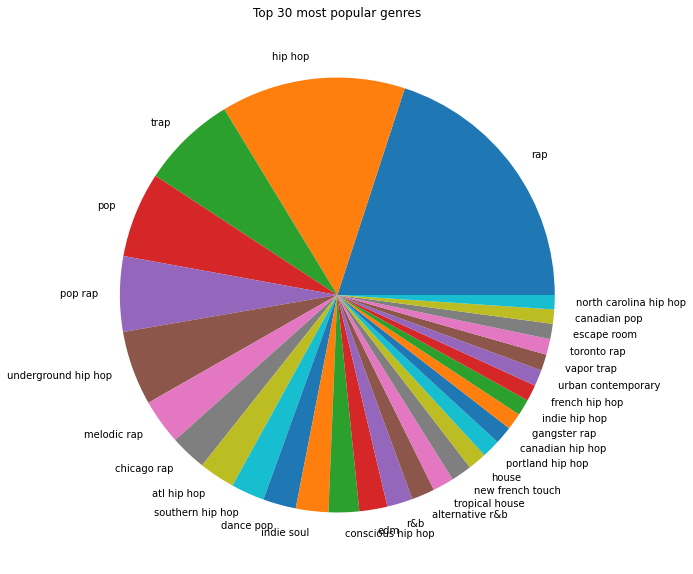

In [174]:
fig = plt.figure(figsize = (10, 10))
ax = fig.subplots()
df_genre_expanded.genres.value_counts()[:30].plot(ax=ax, kind = "pie")
ax.set_ylabel("")
ax.set_title("Top 30 most popular genres")
plt.show()

## Extract time series data

In [33]:
my_streaming["Play-Time"]= pd.to_datetime(my_streaming["end_time"]) # To create a additional column

In [42]:
my_streaming['year'] = pd.DatetimeIndex(my_streaming["Play-Time"]).year
my_streaming['month'] = pd.DatetimeIndex(my_streaming["Play-Time"]).month
my_streaming['day'] = pd.DatetimeIndex(my_streaming["Play-Time"]).day
my_streaming['weekday'] = pd.DatetimeIndex(my_streaming["Play-Time"]).weekday
my_streaming['time'] = pd.DatetimeIndex(my_streaming["Play-Time"]).time
my_streaming['hours'] = pd.DatetimeIndex(my_streaming["Play-Time"]).hour
my_streaming['day-name'] = my_streaming["Play-Time"].apply(lambda x: x.day_name())
my_streaming["Time-Played (hh-mm-ss)"] = pd.to_timedelta(my_streaming["ms_played"], unit='ms')
my_streaming["Count"] = 1

In [43]:
def hours(td):
    '''To get the hour information'''
    return td.seconds/3600

def minutes(td):
    '''To get the minutes information'''
    return (td.seconds/60)%60

my_streaming["Listening Time(Hours)"] = my_streaming["Time-Played (hh-mm-ss)"].apply(hours).round(3)
my_streaming["Listening Time(Minutes)"] = my_streaming["Time-Played (hh-mm-ss)"].apply(minutes).round(3)

### Top 10 artists by total listening time

In [49]:
top_10_artist_time_df = my_streaming.groupby(["artist_name"])[["Listening Time(Hours)","Listening Time(Minutes)","Count"]].sum().sort_values(by="Listening Time(Minutes)",ascending=False)
top_10_artist_time_df.head(10)

,Listening Time(Hours),Listening Time(Minutes),Count
artist_name,,,
Kanye West,25.309,1518.217,411
Kid Cudi,10.275,616.553,189
Kendrick Lamar,9.600,576.224,150
Childish Gambino,9.435,565.178,137
J. Cole,9.382,562.525,158
Drake,8.372,502.979,128
Garden City Movement,7.503,450.539,141
Aminé,7.239,434.858,189
Pachanga Boys,6.953,416.623,34


In [50]:
# fig,ax = plt.subplots(figsize=(12,8))
# ax.bar(top_10_artist_time_df.head(10).index,top_10_artist_time_df["Listening Time(Hours)"].head(10),color='green')
# ax.set(title="My Top 10 Favourite Artist (based on Hours)",xlabel="Artists",ylabel="No. of Hours Songs Played");
# plt.xticks(rotation=75);

### top 10 artists by total number of times streamed

In [51]:
top_10_artist_count_df = my_streaming.groupby(["artist_name"])[["Listening Time(Hours)","Listening Time(Minutes)","Count"]].sum().sort_values(by="Count",ascending=False)
top_10_artist_count_df.head(10)

,Listening Time(Hours),Listening Time(Minutes),Count
artist_name,,,
Kanye West,25.309,1518.217,411
Kid Cudi,10.275,616.553,189
Aminé,7.239,434.858,189
J. Cole,9.382,562.525,158
Kendrick Lamar,9.600,576.224,150
Garden City Movement,7.503,450.539,141
Childish Gambino,9.435,565.178,137
Drake,8.372,502.979,128
Jack Harlow,4.409,265.607,113


In [52]:
# fig,ax = plt.subplots(figsize=(12,8))
# ax.bar(top_10_artist_count_df.head(10).index,top_10_artist_count_df["Count"].head(10),color='orange')
# ax.set(title="My Top 10 Favourite Artist (based on Counts)",xlabel="Artists",ylabel="No. of Times Songs Played");
# plt.xticks(rotation=75);

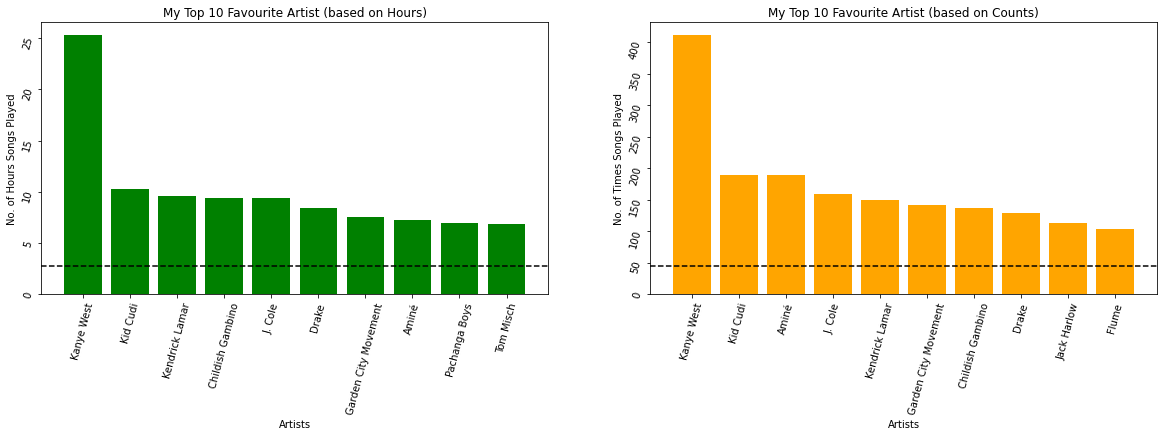

In [53]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,5))

# Setting up our first graph
ax1.bar(top_10_artist_time_df.head(10).index,top_10_artist_time_df["Listening Time(Hours)"].head(10), color="green")
ax1.set(title="My Top 10 Favourite Artist (based on Hours)",xlabel="Artists",ylabel="No. of Hours Songs Played");
ax1.tick_params(labelrotation=75);
ax1.axhline(top_10_artist_time_df["Listening Time(Hours)"][:100].mean(), linestyle="--", color="black")

# Setting up our seecond graph
ax2.bar(top_10_artist_count_df.head(10).index,top_10_artist_count_df["Count"].head(10), color="orange")
ax2.set(title="My Top 10 Favourite Artist (based on Counts)",xlabel="Artists",ylabel="No. of Times Songs Played");
ax2.tick_params(labelrotation=75);
ax2.axhline(top_10_artist_count_df["Count"][:100].mean(), linestyle="--", color="black");

### Daily Usage

Here we'll try to analyse whats is the percentage usage of Spotify Streaming over a Week.

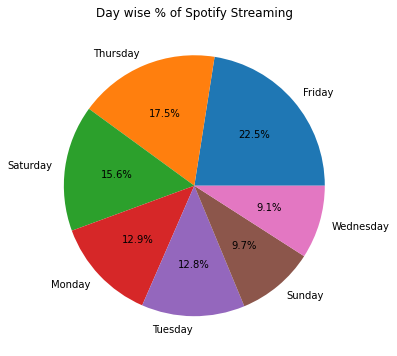

In [54]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.pie(my_streaming["day-name"].value_counts(), labels=my_streaming["day-name"].value_counts().index, autopct='%1.1f%%');
ax.set(title="Day wise % of Spotify Streaming");

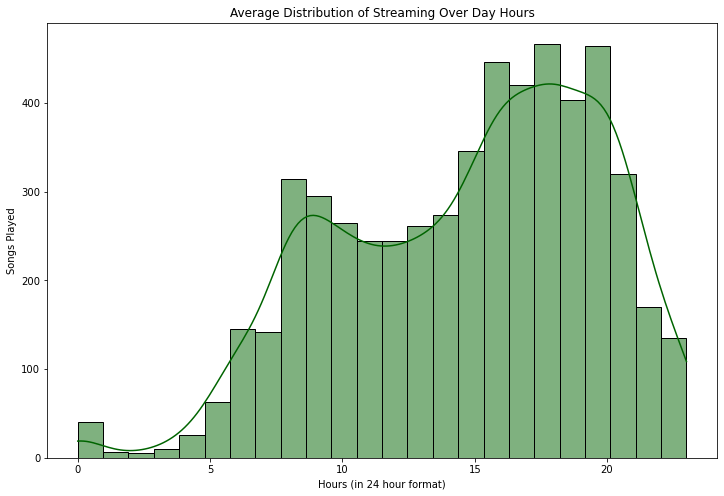

In [55]:
fig, ax = plt.subplots(figsize=(12,8))
ax.set(title="Average Distribution of Streaming Over Day Hours",xlabel="Hours (in 24 hour format)", ylabel="Songs Played")
sns.histplot(my_streaming["hours"], bins=24,kde=True, color="darkgreen");

### Day with maximum number of song

In [56]:
my_streaming["date"] = my_streaming["Play-Time"].dt.date # Creating a new column with date

Here we created another column called `date` which has the date that we calculated from the original `Play-Time` column.

In [57]:
most_songs = my_streaming.groupby(["date"])[["Count"]].sum().sort_values(by="Count", ascending=False)
most_songs.head()

,Count
date,
2021-11-26,146
2021-05-11,90
2021-06-05,89
2021-09-17,89
2021-04-26,81


### Heatmap of spotify usage by hour of day VS day of week

In [58]:
active_usage = my_streaming.groupby(['hours', 'day-name'])['artist_name'].size().reset_index()
active_usage_pivot = active_usage.pivot("hours", 'day-name', 'artist_name')
active_usage_pivot.head()

day-name,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hours,,,,,,,
0,3.0,NaN,9.0,1.0,1.0,3.0,23.0
1,NaN,NaN,NaN,NaN,4.0,1.0,1.0
2,5.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,4.0,NaN,NaN,NaN,3.0,3.0
4,NaN,4.0,NaN,NaN,NaN,12.0,10.0


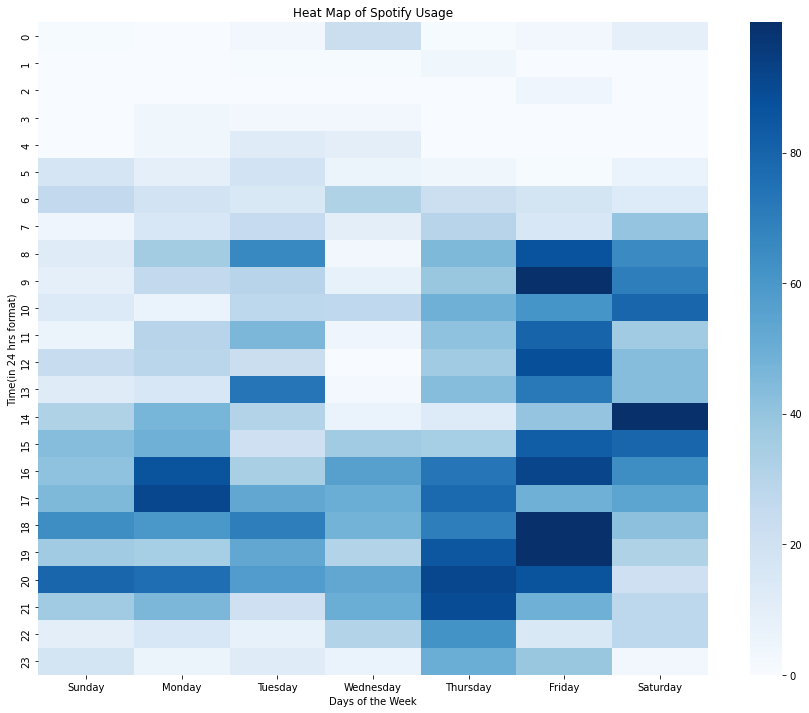

In [59]:
days = ["Sunday", "Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday"]

fig, ax = plt.subplots(figsize=(15,12))
ax = sns.heatmap(active_usage_pivot[days].fillna(0), robust=True, cmap="Blues", ax = ax);
ax.set(title="Heat Map of Spotify Usage", xlabel="Days of the Week",ylabel="Time(in 24 hrs format)");
plt.savefig("usage_heatmap.png")

In [61]:
from wordcloud import WordCloud

artist_freq = my_streaming.groupby('artist_name',as_index=False).sum()[['artist_name','ms_played']]
artist_freq

artist_freq = dict(zip(artist_freq['artist_name'].tolist(), artist_freq['ms_played'].tolist()))

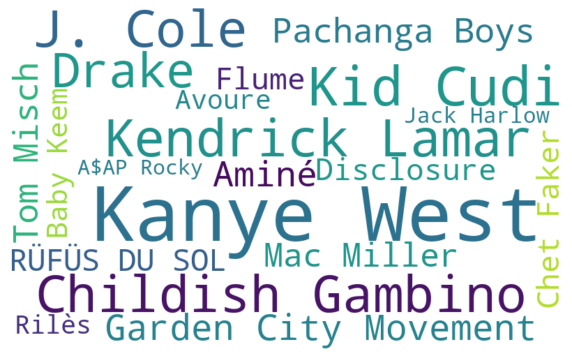

In [62]:
wc = WordCloud(background_color='white',width=800, height=500, max_words=20).generate_from_frequencies(artist_freq)
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [60]:
#convert loudness to the scale of 0-1.
def convert_scale(df,col):
    new_max = 1
    new_min = 0
    new_range = new_max-new_min
    max_val = df[col].max()
    min_val=df[col].min()
    val_range = max_val - min_val
    df[col+'_adj']=df[col].apply(lambda x: (((x-min_val)*new_range)/val_range)+new_min)
    return

convert_scale(my_streaming,'loudness')
convert_scale(my_streaming_uniq,'loudness')

# For network

In [98]:
# generate access token
CLIENT_ID = 'XXXXXXXXXXXXX'
CLIENT_SECRET = 'XXXXXXXXXXXXX' 
# authentication URL
AUTH_URL = 'https://accounts.spotify.com/api/token'
scope = "user-library-read"
# POST
auth_response = requests.post(AUTH_URL, {
    'grant_type': 'client_credentials',
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
})

# convert the response to JSON
auth_response_data = auth_response.json()

# save the access token
access_token = auth_response_data['access_token']
headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}
BASE_URL = 'https://api.spotify.com/v1/'
scope = "user-library-read"
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(CLIENT_ID, CLIENT_SECRET, redirect_uri='http://localhost/', scope=scope))

In [88]:
CLIENT_ID = "XXXXXXXXXXXXX"
CLIENT_SECRET = "XXXXXXXXXXXXX"
token = util.spotipy.SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
cache_token = token.get_access_token()
spotify = spotipy.Spotify(cache_token['access_token'])

/var/folders/y5/h13xjq_n3j31nfzvt6gx755c0000gn/T/ipykernel_8823/1572541171.py:9: DeprecationWarning:

You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.



# Filter to keep only artsits that where streamed more than 40 times


In [82]:
ar = spotify_data.groupby(['artist_name']).size().sort_values()
pd.DataFrame({"artist":ar[ar > 40].index})

to_netwrok = pd.merge(pd.DataFrame({"artist":ar[ar > 40].index}),my_streaming_uniq[["artist", "artist_id"]].drop_duplicates(),how="left",left_on= "artist", right_on="artist")

In [83]:
to_netwrok = to_netwrok.drop_duplicates(subset = "artist")

In [84]:
artists = list(to_netwrok.artist_id)

In [167]:
len(artists)

44

# Functions to create our network

In [89]:
# Grab data for a single artist by text/name
def artistDataName(artist):
    # Grab raw JSON data
    rawData = spotify.search(q=artist, limit=1, offset=0, type='artist')
    # Filters down to first artist's data
    artist = rawData['artists']['items'][0]
    return artist

# Grab data for a single artist by ID
def artistDataID(artistID):
    # Grab raw JSON data
    rawData = spotify.artist(artistID)
    # Filters down to first artist's data
    # artist = rawData['artists']['items'][0]
    return rawData

def getArtistName(artistID):
    name = spotify.artist(artistID)['name']
    return name


# Grab Related from Spotify -- Returns 20 artists
def getRelatedArtists(artistID):
    related = spotify.artist_related_artists(artistID)
    return related

def getTopTracks(artistID):
    top = spotify.artist_top_tracks(artistID)
    return top

def getAudioFeatures(song1ID):
    songFeatures = spotify.audio_features([song1ID])
    return songFeatures

def getSongName(songID):
    data  = spotify.track(songID)
    return data['name']

def getArtistGenres(artistID):
    genres = artistDataID(artistID)['genres']
    return genres

def getArtistID(artistName):
    return artistDataName(artistName)['id']

In [90]:
# Use related artists to make a network -- returns a Graph
def makeArtistNetwork(artistID):
    
    artist = artistDataID(artistID)
    related = getRelatedArtists(artistID)['artists']
    
    G = nx.Graph()
    # Add main artist node
    G.add_node(artist['name'], id=artist['id'], genres=artist['genres'], followers=artist['followers']['total'], popularity=artist['popularity'])
    
    # Add related artist nodes to graph
    for a in related:
        G.add_node(a['name'], id=a['id'], genres=a['genres'], followers=a['followers']['total'], popularity=a['popularity'])
        
        # Add edge between the core artist and secondary
        G.add_edge(str(artist['name']), str(a['name']),weight = artistSimilarityScore(artist['id'], a['id']) )
    
    return G

In [91]:
# Score of similar genres between artists
def genreScore(artist1ID, artist2ID):
    
    count = 0
    artist1Genres = artistDataID(artist1ID)['genres']
    artist2Genres = artistDataID(artist2ID)['genres']

    for g in artist1Genres:
        if g in artist2Genres:
            count += 1

    pct = count / len(artist1Genres)
    return pct

In [92]:
# Calculate similarity of 2 artists top songs
def topSongScore(artistID1, artistID2):


    topSongs1 = [ track['id'] for track in getTopTracks(artistID1)['tracks'] ]
    topSongs2 = [ track['id'] for track in getTopTracks(artistID2)['tracks'] ]
    
    score = 0

    for i in topSongs1:
        for j in topSongs2:
            score += songSimilarity(i, j)
    
    return score/100

In [93]:
# Calculate song similarity number based on valence, mode, and energy
def songSimilarity(song1ID, song2ID):

    song1Features = getAudioFeatures(song1ID)
    song2Features = getAudioFeatures(song2ID)


    if song1Features[0] is None or song2Features[0] is None:
        valenceScore = 0.5
        energyScore = 0.5
        danceScore = 0.5
        
       
    else:
        valenceScore = 1 - (abs(song1Features[0]['valence'] - song2Features[0]['valence']))
        energyScore = 1 - (abs(song1Features[0]['energy'] - song2Features[0]['energy']))
        danceScore = 1 - (abs(song1Features[0]['danceability'] - song2Features[0]['danceability']))
    
    if song1Features[0] is None or song2Features[0] is None:
        mode = 0.5
        
    else:
        if (song1Features[0]['mode'] == song2Features[0]['mode']):
            mode = 1
        else:
            mode = 0

    score = (valenceScore + energyScore + mode + danceScore) / 4
    
    return score

In [94]:
def artistSimilarityScore(artist1ID, artist2ID):
    genre = genreScore(artist1ID, artist2ID)
    topSongs = topSongScore(artist1ID, artist2ID)
    score = (genre + topSongs) / 2
    return score 

In [131]:
artists_networks = []

### This code took a long time to run, it contain many API calls, we created the network edges list and saved it (final_artist_weights.csv)

In [ ]:
#counter = 1
for i in tqdm(range(counter, len(artists))):
    artists_networks.append( makeArtistNetwork(artists[i]))
    counter = counter+1

In [138]:
# change name with "$" to S
for i in tqdm(range(len(artists_networks))):
    if 'Joey Bada$$' in nx.nodes(artists_networks[i]):
        mapping = {'Joey Bada$$':'Joey BadaSS'}
        artists_networks[i] = nx.relabel_nodes(artists_networks[i], mapping)


100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 3389.79it/s]


In [139]:
q = nx.get_edge_attributes(artists_networks[0],'weight')

In [140]:
df_artists = pd.DataFrame(q.keys(), columns =['source', 'target'])
df_weights = pd.DataFrame(q.values(), columns =['weight'])
df_artists_and_weights = pd.concat([df_artists,df_weights], axis = 1)

In [141]:

for i in range(1,len(artists_networks)):
    q = nx.get_edge_attributes(artists_networks[i],'weight')
    df_artists = pd.DataFrame(q.keys(), columns =['source', 'target'])
    df_weights = pd.DataFrame(q.values(), columns =['weight'])
    df_artists_and_weights_temp = pd.concat([df_artists,df_weights], axis = 1)
    df_artists_and_weights = pd.concat([df_artists_and_weights,df_artists_and_weights_temp], axis = 0)

In [148]:
df_artists_and_weights.to_csv('final_artist_weights.csv', index=False, index_label=False)

# The network

In [100]:
df_artists_and_weights = pd.read_csv('final_artist_weights.csv')

In [101]:
G = nx.from_pandas_edgelist(df_artists_and_weights,edge_attr="weight")

## Get a network of the giant commponent only

In [102]:
G = nx.subgraph(G,sorted(nx.connected_components(G), key=len, reverse=True)[0])

In [103]:
network_features = pd.DataFrame.from_dict( {"name" :nx.eigenvector_centrality(G).keys(),
                        "eigen_vector_cantrality": nx.eigenvector_centrality(G,weight="weight").values(),
                        "degree_cantrality": nx.degree_centrality(G).values(),
                        "degree_caount": dict(nx.degree(G)).values(),
                        "betweenness_centrality": nx.betweenness_centrality(G, weight="weight").values()} )

In [104]:
network_features

,name,eigen_vector_cantrality,degree_cantrality,degree_caount,betweenness_centrality
0,Polo & Pan,0.000028,0.049763,21,0.051356
1,Papooz,0.000008,0.007109,3,0.000000
2,Lewis OfMan,0.000013,0.007109,3,0.000000
3,Kazy Lambist,0.000025,0.009479,4,0.063356
4,Agar Agar,0.000006,0.004739,2,0.000000
...,...,...,...,...,...
418,Madvillain,0.011309,0.002370,1,0.000000
419,Spellling,0.003736,0.002370,1,0.000000
420,redveil,0.003746,0.002370,1,0.000000
421,Jay Electronica,0.011407,0.002370,1,0.000000


In [105]:
core_artist = ['A Boogie Wit da Hoodie',
 'A$AP Rocky',
 'Aminé',
 'Anderson .Paak',
 'Avoure',
 'Baby Keem',
 'Chance the Rapper',
 'Chet Faker',
 'Childish Gambino',
 'Daft Punk',
 'Disclosure',
 'Drake',
 'Flume',
 'Franc Moody',
 'Frank Ocean',
 'Garden City Movement',
 'Hermitude',
 'J. Cole',
 'Jack Harlow',
 'Jungle',
 'KIDS SEE GHOSTS',
 'Kanye West',
 'Kendrick Lamar',
 'Kid Cudi',
 'Lil Uzi Vert',
 'Mac Miller',
 'Moi Je',
 'Moksi',
 'Mura Masa',
 'Pachanga Boys',
 'Polo & Pan',
 'Rilès',
 'Roosevelt',
 'RÜFÜS DU SOL',
 'SBTRKT',
 'Sampha',
 'ScHoolboy Q',
 'Seekae',
 'The Blaze',
 'The Homies',
 'The Weeknd',
 'Tom Misch',
 'Two Feet',
 'Young Thug']

In [106]:
network_features_no_core = network_features[~network_features.name.isin(core_artist)]

In [107]:
z = np.abs(stats.zscore(network_features_no_core.eigen_vector_cantrality))
eig = network_features_no_core.iloc[np.where(z > 3)[0],:]
eig

,name,eigen_vector_cantrality,degree_cantrality,degree_caount,betweenness_centrality
97,Isaiah Rashad,0.183655,0.026066,11,0.001250
109,Vince Staples,0.187186,0.026066,11,0.000000
112,Earl Sweatshirt,0.157405,0.023697,10,0.000687
138,Pusha T,0.209004,0.026066,11,0.000000
144,Joey BadaSS,0.178928,0.023697,10,0.000000
148,Freddie Gibbs,0.177910,0.023697,10,0.000000
157,Jay Rock,0.120611,0.011848,5,0.000000
160,2 Chainz,0.109671,0.014218,6,0.000000


In [108]:
z = np.abs(stats.zscore(network_features_no_core.degree_cantrality))
deg = network_features_no_core.iloc[np.where(z > 3)[0],:]
deg

,name,eigen_vector_cantrality,degree_cantrality,degree_caount,betweenness_centrality
97,Isaiah Rashad,0.183655,0.026066,11,0.001250
109,Vince Staples,0.187186,0.026066,11,0.000000
112,Earl Sweatshirt,0.157405,0.023697,10,0.000687
138,Pusha T,0.209004,0.026066,11,0.000000
144,Joey BadaSS,0.178928,0.023697,10,0.000000
148,Freddie Gibbs,0.177910,0.023697,10,0.000000


In [109]:
z = np.abs(stats.zscore(network_features_no_core.betweenness_centrality))
bet = network_features_no_core.iloc[np.where(z > 3)[0],:]
bet

,name,eigen_vector_cantrality,degree_cantrality,degree_caount,betweenness_centrality
60,NxWorries,4.986027e-04,0.004739,2,0.087897
62,Rejjie Snow,3.355597e-03,0.007109,3,0.153820
67,Phony Ppl,1.133376e-02,0.007109,3,0.247312
80,Loyle Carner,8.361584e-05,0.004739,2,0.207101
176,Darius,1.816216e-05,0.014218,6,0.188087
243,Tchami,2.838353e-07,0.004739,2,0.090509
352,Kidnap,2.463799e-06,0.004739,2,0.090509


In [110]:
recommend = pd.concat([bet,eig,deg], axis = 0).drop_duplicates()
recommend

,name,eigen_vector_cantrality,degree_cantrality,degree_caount,betweenness_centrality
60,NxWorries,4.986027e-04,0.004739,2,0.087897
62,Rejjie Snow,3.355597e-03,0.007109,3,0.153820
67,Phony Ppl,1.133376e-02,0.007109,3,0.247312
80,Loyle Carner,8.361584e-05,0.004739,2,0.207101
176,Darius,1.816216e-05,0.014218,6,0.188087
243,Tchami,2.838353e-07,0.004739,2,0.090509
352,Kidnap,2.463799e-06,0.004739,2,0.090509
97,Isaiah Rashad,1.836553e-01,0.026066,11,0.001250
109,Vince Staples,1.871860e-01,0.026066,11,0.000000
112,Earl Sweatshirt,1.574049e-01,0.023697,10,0.000687


In [111]:
color_map = []
for node in G:
    if node in list(recommend.name):
        color_map.append('red')
    else: 
        color_map.append('lightblue')

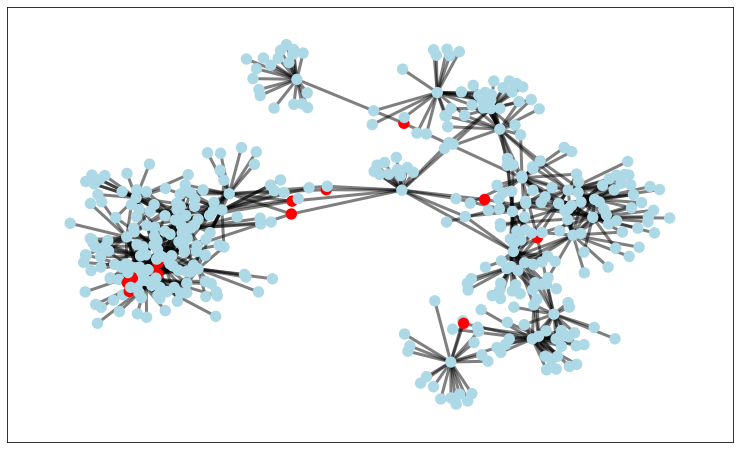

In [112]:
pos = nx.drawing.spring_layout(G, k=0.7, iterations=400)
plt.figure(figsize=(13,8))
nx.draw_networkx_nodes(G, pos, node_size=70, linewidths = 3, node_color=color_map)
nx.draw_networkx_edges(G,pos,width=3,edge_color='black',alpha=0.5)
plt.show()

# Test out results

In [115]:
#Filter to keep only artsits that where streamed more than 40 times
test = spotify_data.groupby(['artist_name']).size().sort_values()
test = test[test < 40]

In [123]:
Sucesess = 0
for i in recommend.name:
    if i in list(test.index):
        Sucesess+=1    

In [129]:
print("Out of the 15 artist we reccomended,", Sucesess, "of them were right")

Out of the 15 artist we reccomended, 9 of them were right
